In [ ]:
#base map for world-plotting

!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip (133.1 MB)


In [ ]:
pip install bds_courseware

In [ ]:
!pip3 install pandas-profiling==2.8.0

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import warnings
import pandas_profiling
import scipy.stats
import seaborn as sns
warnings.filterwarnings('ignore')

from pandas_profiling import ProfileReport
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm as cm
import plotly.express as px
import itertools
import plotly
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

from mpl_toolkits.basemap import Basemap

from sklearn.datasets import load_wine
from tqdm.notebook import tqdm as tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from math import cos,sin
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, silhouette_samples

In [ ]:
from bds_courseware import read_drive_dataset
from bds_courseware import print_dataset_description, print_module_datasets
from bds_courseware import HOMEWORK_DATASETS

In [ ]:
name = "quake"
df = read_drive_dataset(*HOMEWORK_DATASETS[name])
print(df.head(2))
print(df.shape)

   Focal depth  Latitude  Longitude  Richter
0           33    -52.26      28.30      6.7
1           36     45.53     150.93      5.8
(2178, 4)


In [ ]:
df.head()

Focal depth  Latitude  Longitude  Richter
0           33    -52.26      28.30      6.7
1           36     45.53     150.93      5.8
2           57     41.85     142.78      5.8
3           67     29.19     141.15      6.2
4           30    -21.66     169.81      6.0

In [ ]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and then plot the dendrogram"""
    # create the counts of samples under each node
    plt.figure(figsize=(30, 10))
    plt.title('Hierarchical Clustering Dendrogram')

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
    counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.xticks(fontsize=20, rotation=70)
    plt.show()

# 1. EDA

In [ ]:
report = pandas_profiling.ProfileReport(df)
#report

In [ ]:
df["Richter"].value_counts()

5.8    691
5.9    518
6.0    370
6.1    228
6.2    158
6.3     95
6.4     53
6.5     44
6.6     11
6.7      6
6.9      2
6.8      2
Name: Richter, dtype: int64

Profiling conclusions:

1) No missing values 

2) Longitude and latitude coordinates cover almost entire Earth (no earthquake registered in South Pole though) 

3) Richter values are discrete values from [5.8 ; 6.9] with 0.1 step. 
and the more value is -- the less frequency of the value 

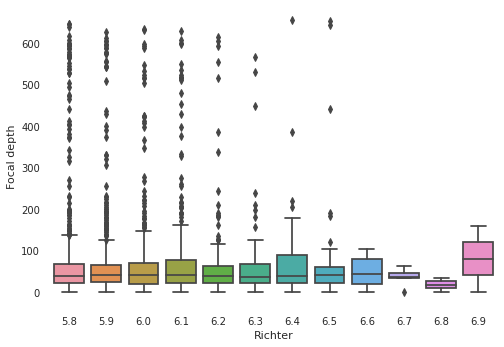

In [ ]:
sns.boxplot(y ="Focal depth", x = "Richter", data = df)

Focal depth medians are pretty much the same for each Richter values, with the exception of high one -- but there are very few observations (only 2 for 6.8 and 6.9)

Since coordinates  has a problem (-180 = +180, and 170 is much closer to -180 than to 0, for example)
let's translate this into 3d-sphere using 3 coordinates instead of 2.

Anothee benifit of this tranformation as it is already normalized [-1,1]

In [ ]:
#convert from degrees to radians
lat = df["Latitude"]* np.pi/180
lon = df["Longitude"] * np.pi/180


df["x"] = np.cos(lat) * np.cos(lon)
df["y"] = np.cos(lat) * np.sin(lon)
df["z"] = np.sin(lat) 

Illustration of the tranformation:

In [ ]:
fig = px.scatter_3d(df,"x", "z", "y")
fig.show()

In [ ]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(df.drop(columns=["Latitude","Longitude"]))
X_scaled = pd.DataFrame(X_scaled)

# 2. Clustering

## 2.1 KMeans with 15 classes

In [ ]:
#PCA tranformation
pca = PCA(n_components=2)

X_2d = pca.fit_transform(X_scaled)

In [ ]:
df['pca_x'], df['pca_y'] = X_2d[:, 0], X_2d[:, 1]

In [ ]:
kmeans = KMeans(n_clusters=15).fit_predict(X_scaled)

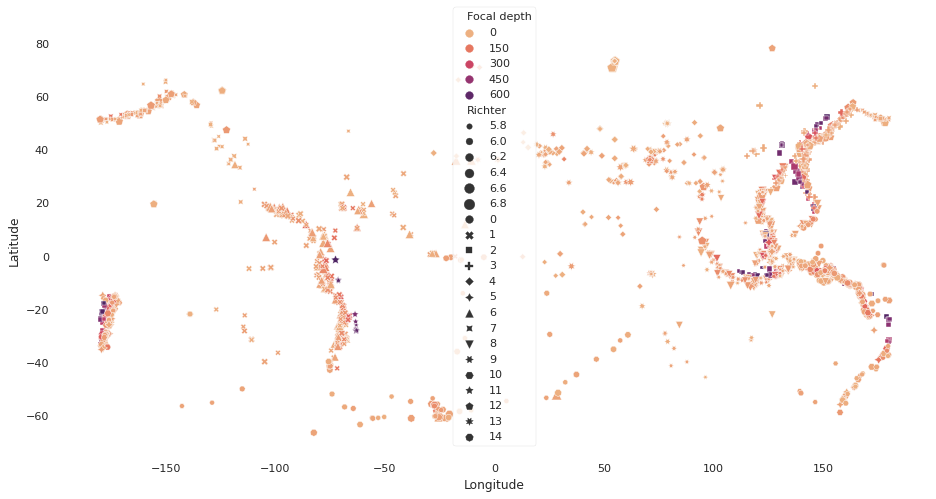

In [ ]:
figure(figsize=(14,7), dpi=80)
sns.scatterplot(x = df["Longitude"],y=df["Latitude"], hue = "Focal depth",palette = "flare",size = "Richter",style = kmeans, data = df)

Attemt to illustrate all 4 features on single scatter plot without PCA is a mess

In [ ]:
fig = px.scatter_3d(df,"x", "z", "y",color = kmeans)
fig.show()

In [ ]:
fig = px.scatter(df, x='pca_x', y='pca_y', color=kmeans)

fig.update_layout(title='Earthquake 2d PCA space')
fig.show()

Even PCA plots are mess.  Let's check that using algorithms.

##2.2 Finding optimal amount of clusters

###2.2.1 Elbow method

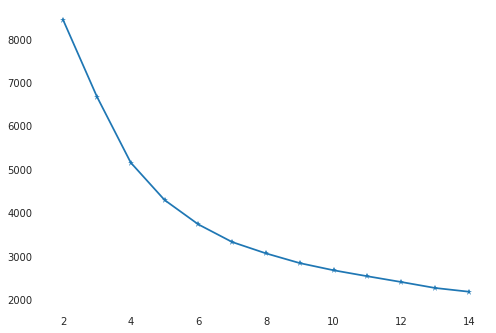

In [ ]:
inertias = []
n_clust_grid = [i for i in range(2, 15)]
for n_clusters in n_clust_grid:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)

plt.plot(n_clust_grid, inertias, marker="*")

According to elbow method it's hard to say the exact value -- it has to be between 5 and 8, let's check using another method

### 2.2.2 Silhouette method

In [ ]:
def calculate_silhouette(model, X, max_num_clusters=5):
    for n_clusters in range(2, max_num_clusters):
        clusterer = model(n_clusters=n_clusters, random_state=0)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters, \
              "The average silhouette_score is :", silhouette_avg)

In [ ]:
calculate_silhouette(model=KMeans, 
               X=X_scaled,
               max_num_clusters=15)

For n_clusters = 2 The average silhouette_score is : 0.33121750067410366
For n_clusters = 3 The average silhouette_score is : 0.2847265185540051
For n_clusters = 4 The average silhouette_score is : 0.32172221809520474
For n_clusters = 5 The average silhouette_score is : 0.3291872336028197
For n_clusters = 6 The average silhouette_score is : 0.34169225809088144
For n_clusters = 7 The average silhouette_score is : 0.3198454464234616
For n_clusters = 8 The average silhouette_score is : 0.31906802893002273
For n_clusters = 9 The average silhouette_score is : 0.3139537181226513
For n_clusters = 10 The average silhouette_score is : 0.3135676216476831
For n_clusters = 11 The average silhouette_score is : 0.29769916265311236
For n_clusters = 12 The average silhouette_score is : 0.2985629690302313
For n_clusters = 13 The average silhouette_score is : 0.30048085046938483
For n_clusters = 14 The average silhouette_score is : 0.3012002274207996


According to silhouette method best value is 4, which is slighly better than 3.
Since it has nearly same values, having more clusters can be more usefull, so the final result will be **6 clusters**

## 2.3 Visualization for obtained clusters

In [ ]:
df["k_labels"] = KMeans(n_clusters=6,random_state=42).fit_predict(X_scaled)


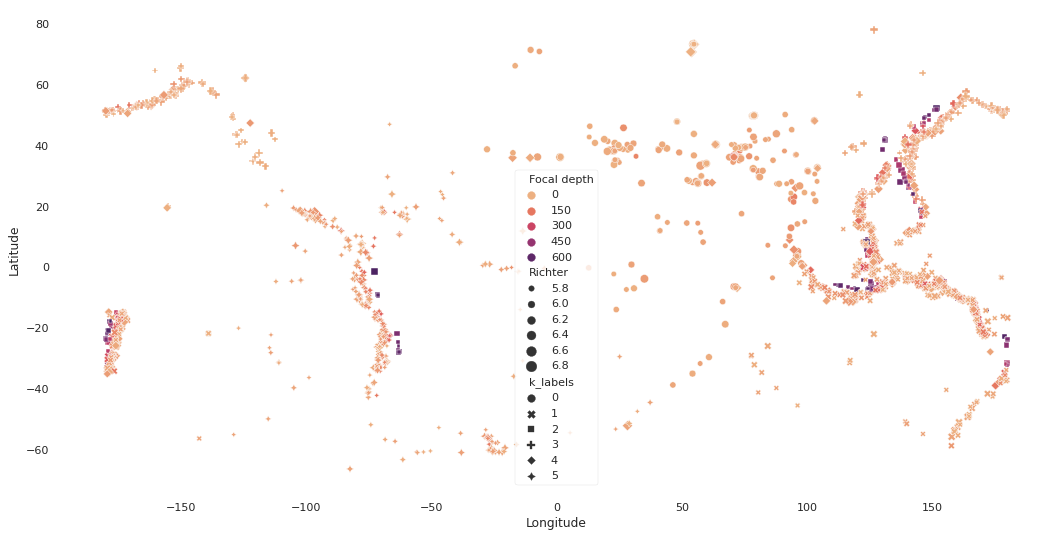

In [ ]:
figure(figsize=(16,8), dpi=80)
sns.scatterplot(x = df['Longitude'],y=df["Latitude"],size = "Richter",palette = "flare",hue = "Focal depth",style = "k_labels", data = df)

In [ ]:
fig = px.scatter_3d(df,"x", "z", "y",color = "k_labels",size = "Focal depth",hover_data=["Richter"])
fig.show()

In [ ]:
fig = px.scatter(df, x='pca_x', y='pca_y', color="k_labels")
fig.update_layout(title='Earthquake 2d PCA space')
fig.show()

##2.4 Other clusterization algoritms 

### 2.4.1 Agglomerative Clustering

In [ ]:
def fit_plot_clusters(model,data,title):
  y = model.fit_predict(data)
  fig = px.scatter(df, x='pca_x', y='pca_y', color=y)
  fig.update_layout(title='{} clustering labels in PCA space'.format(title))
  fig.show()
  return y;

In [ ]:
#using same cluster amount as in k-means
agglomerative = AgglomerativeClustering(n_clusters=6,linkage="ward")
fit_plot_clusters(agglomerative,X_scaled,"Agglomerative");

Results are very close to kmeans in "separate" clusters (like orange or yellow) but differs a lot where points are really close to each other. Also clusters with close points has a lot intersections inside, which is not good.

#### Parametr tuning

Let's tune two most parametrs: type of *linkage*, and amount of *n_clusters*.

To observe amount of clusters, let's plot an denrogram

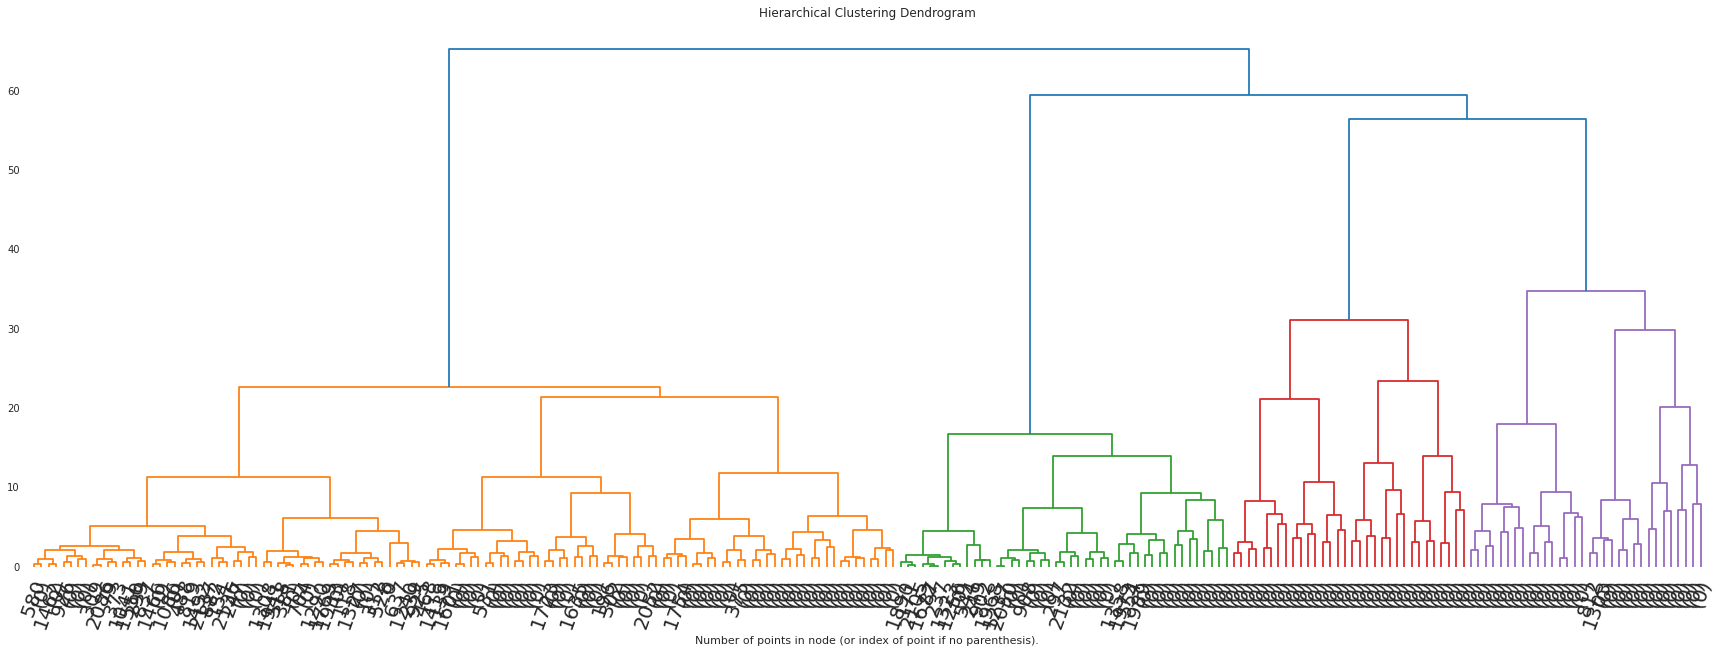

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X_scaled)

plot_dendrogram(model, truncate_mode='level', p=7) # p=3,5,7

accordung to this chart, there is obvious **4 big classes**

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=4)
fit_plot_clusters(agglomerative,X_scaled,"4-clusters Agglomerative");

With 4 clusters results are more clear, while still little messy between 1 and 0 classes. 

Let's try another linkages.

##### *Complete linkage*

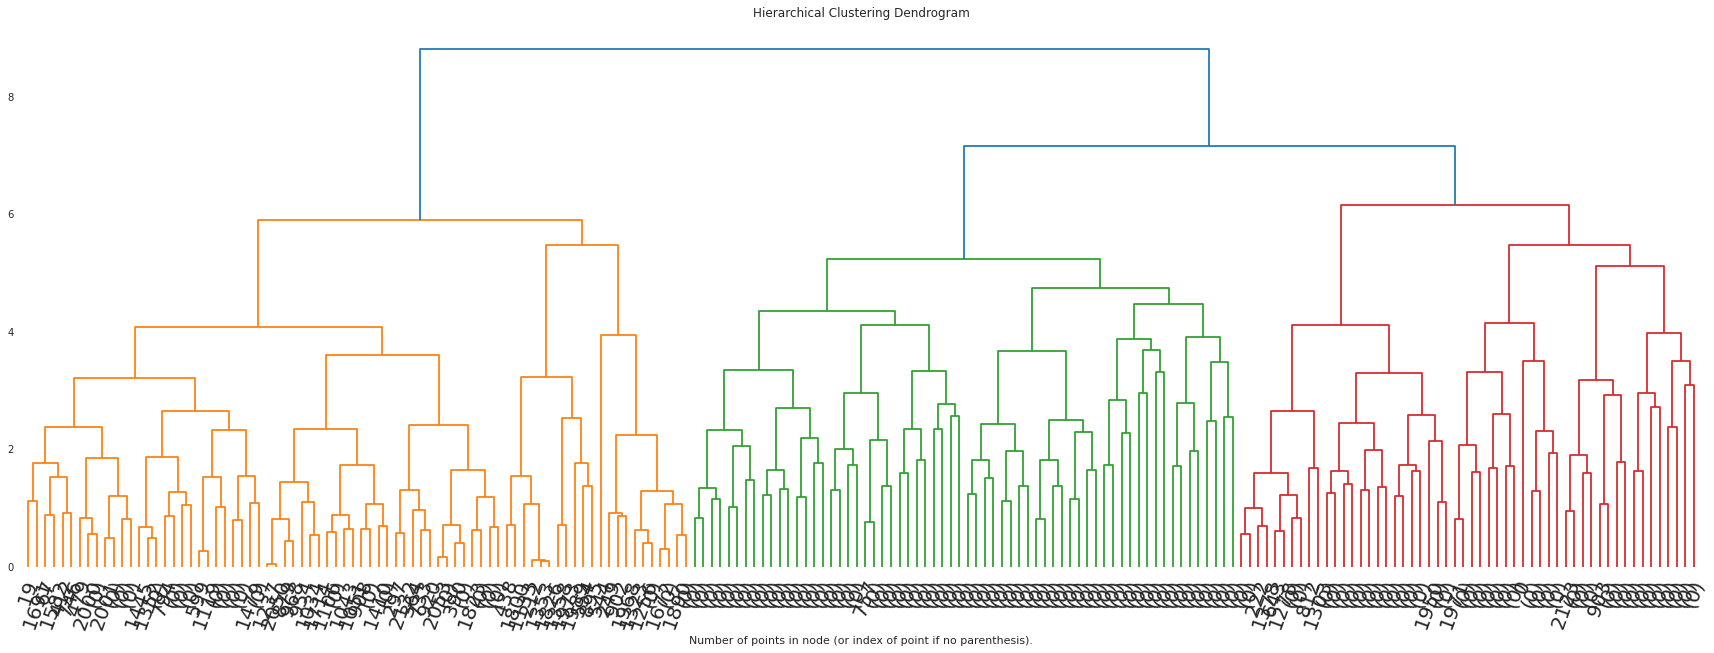

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="complete")
model = model.fit(X_scaled)

plot_dendrogram(model, truncate_mode='level', p=7) # p=3,5,7

On this denrogramm is harder to say correct number of clusters, let's stay with **3 clusters.**

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=3,linkage="complete")
fit_plot_clusters(agglomerative,X_scaled,"Complete Agglomerative")

array([0, 2, 2, ..., 1, 2, 2])

Now it has 1 dominant class and pretty messy clusterization. Since there are no reasons in data to be big "0 class", the default one ("ward") look better

##### *Single linkage*

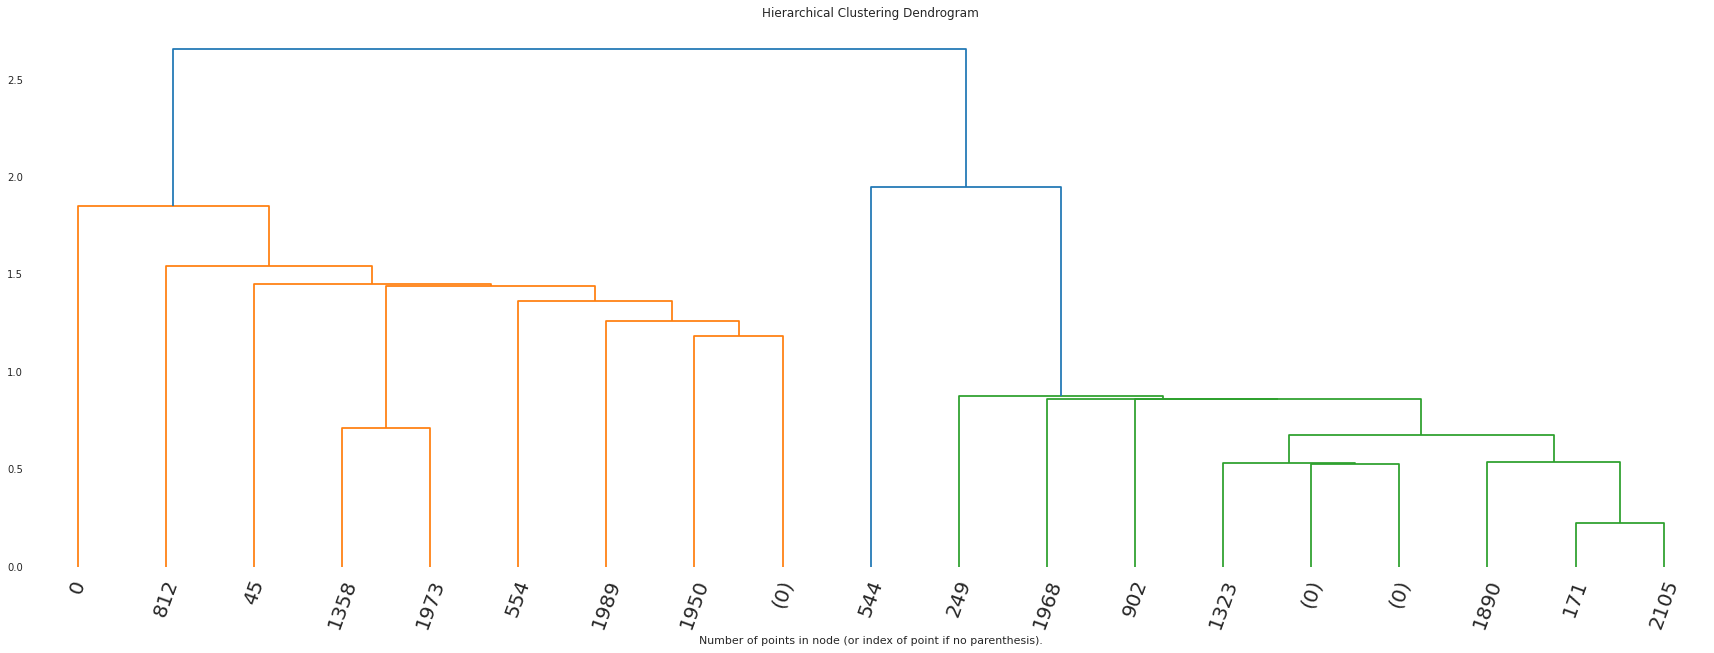

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="single")
model = model.fit(X_scaled)

plot_dendrogram(model, truncate_mode='level', p=7) # p=3,5,7

According to the denrogramm let's take **4 clusters**

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=4,linkage="single")
fit_plot_clusters(agglomerative,X_scaled,"Single Agglomerative")

array([3, 0, 0, ..., 0, 0, 0])

"Single" clusterization combine nearly all observation in sigle cluster, which is obviously bad. 


---



##### Results

According to this obervation best linkage is "ward" (default one) with 4 clusters.

But since ground truth is coming from KMeans, we should use the same clusters amount. So the final result is **"ward" linkage with 6 clusters**



In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=6)
agg_labels = fit_plot_clusters(agglomerative,X_scaled,"Agglomerative");

In [ ]:
agglomerative_labels_mapping = dict(zip([0, 1, 2,3,4,5], [3,1,4,5,0,2]))

In [ ]:
df['agglomerative_label'] = pd.Series(agg_labels).map(agglomerative_labels_mapping)

### 2.4.2 DBScan clustering

#### Default params

In [ ]:
dbscan = DBSCAN()
fit_plot_clusters(dbscan,X_scaled,"DBSCAN");

So by default it has created 34 clusters miwh PLENTY of data being outliar, so let's tune it's parameters.

#### Tuning parameters

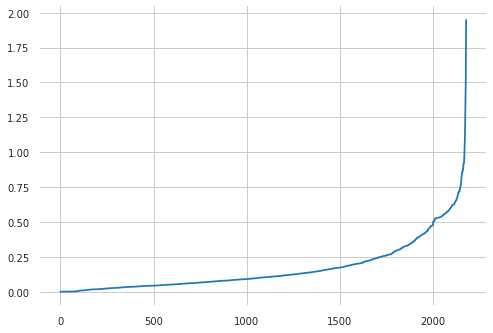

In [ ]:
neighbours = NearestNeighbors(n_neighbors=2)
nbrs = neighbours.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.grid(True)

In [ ]:
dbscan = DBSCAN(eps=0.51, min_samples=X_scaled.shape[1]+1)
y_dbscan = dbscan.fit_predict(X_scaled)

In [ ]:
fig = px.scatter(df, x='pca_x', y='pca_y', color=y_dbscan)
fig.update_layout(title='Red wine sorts in 2d PCA space (DBSCAN labels)')
fig.show()

From human perspective result is more or less the same that with default params. Anyway -- this best params creating too many clusters. Our goal is to compare cluster labels, so we have to set number of clusters like it was in K_means. So we must use 6 clusters.

To find params which gives us exactly 6 clusters, let's use params grid search

In [ ]:
epsilon_param_options = np.arange(0.001, 10, 0.01)
min_samples_param_options = np.arange(2, X_scaled.shape[1]+1, 1)
param_grid = itertools.product(epsilon_param_options, min_samples_param_options)

print('Amount of hyperparameters combinations: {}'.format(len(epsilon_param_options) * len(min_samples_param_options)))

Amount of hyperparameters combinations: 4000


In [ ]:
params_dict = {}
CLUSTER_AMOUNT = 6

for param_set in tqdm(param_grid, total=len(epsilon_param_options) * len(min_samples_param_options)):
  dbscan = DBSCAN(eps=param_set[0], min_samples=param_set[1])

  y_dbscan = dbscan.fit_predict(X_scaled)

  if len(set(y_dbscan) - set([-1])) == CLUSTER_AMOUNT:
    params_dict['{}_{}_{}'.format(len(set(y_dbscan) - set([-1])), param_set[0], param_set[1])] = param_set

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
params_dict

{'6_0.011_4': (0.011, 4),
 '6_0.020999999999999998_5': (0.020999999999999998, 5),
 '6_0.7809999999999999_4': (0.7809999999999999, 4),
 '6_0.7909999999999999_4': (0.7909999999999999, 4),
 '6_0.8009999999999998_4': (0.8009999999999998, 4),
 '6_0.8109999999999998_4': (0.8109999999999998, 4),
 '6_0.8209999999999998_4': (0.8209999999999998, 4),
 '6_0.8409999999999999_4': (0.8409999999999999, 4),
 '6_0.8509999999999999_4': (0.8509999999999999, 4),
 '6_1.0209999999999997_2': (1.0209999999999997, 2)}

There are plenty variations which are really different (0.02 eps vs 1.02), let's check the most extreme ones:

In [ ]:
dbscan = DBSCAN(eps=params_dict['6_0.011_4'][0], min_samples=params_dict['6_0.011_4'][1])
fit_plot_clusters(dbscan,X_scaled,"DBSCAN");

This clusterization makes no sense, so let's check another one

In [ ]:
dbscan = DBSCAN(eps=params_dict['6_0.8509999999999999_4'][0], min_samples=params_dict['6_0.8509999999999999_4'][1])
fit_plot_clusters(dbscan,X_scaled,"DBSCAN");

This clusterization is very poor too. To avoid manual check every params, let's check best clusterization according to Calinski Harabasz score

In [ ]:
bestparam = 0;
max_score = 0;
for param in params_dict:
  dbscan = DBSCAN(eps=params_dict[param][0], min_samples=params_dict[param][1])
  y_dbscan = dbscan.fit_predict(X_scaled)
  sc = calinski_harabasz_score(X_scaled, y_dbscan);
  if (sc>max_score): 
    bestparam = param;
    max_score = sc;
  print(f'Calinski Harabasz score = {sc}')
print("Best params id: ", bestparam)

Calinski Harabasz score = 9.035189227799933
Calinski Harabasz score = 9.42019657183502
Calinski Harabasz score = 38.207954246645365
Calinski Harabasz score = 37.95288306423933
Calinski Harabasz score = 37.70798478311466
Calinski Harabasz score = 37.70798478311466
Calinski Harabasz score = 37.70798478311466
Calinski Harabasz score = 28.41854434399418
Calinski Harabasz score = 28.434707167887296
Calinski Harabasz score = 19.772740287283657
Best params id:  6_0.7809999999999999_4


In [ ]:
#fit the model with best params
dbscan = DBSCAN(eps=params_dict[bestparam][0], min_samples=params_dict[bestparam][1])
y_dbscan = dbscan.fit_predict(X_scaled)

fig = px.scatter(df, x='pca_x', y='pca_y', color=y_dbscan)
fig.update_layout(title='Red wine sorts in 2d PCA space (DBSCAN labels)')
fig.show()

In [ ]:
#saving results
df["dbscan_labels"] = y_dbscan

#### Conclusions

Results are very bad -- even with "best" params it still shows poor perfomance with 6 clusters. 

Results without specifying amount of cluster are bad too -- DBSCAN is creating too many clusters and clusters themselves intercept a lot.

There is a common knowledge that DBSCAN show poor perfomance when density varies across clusters, and that's exactly our case.
This can be a reason for such a bad results.

# 3. Cluster quality estimation

## 3.1 Labeled metrics

Since DBSCAN has shown very bad results for 6 clusters, it makes no sense to use K_means labels as ground truth to estimate it's results -- it is clear that results are very bad. 

Also, it is useless to calculate these values for k_labels -- because we took it as ground truth. So let's calculate label metrics only for aggromerative clustering to obtain meaningfull results.

In [ ]:
print(f'Adjusted MI score for Agglomerative_label = {adjusted_mutual_info_score(df["k_labels"], df["agglomerative_label"])}')
print(f'Adjusted rand score for Agglomerative_label = {adjusted_rand_score(df["k_labels"], df["agglomerative_label"])}')

Adjusted MI score for Agglomerative_label = 0.6634933327611219
Adjusted rand score for Agglomerative_label = 0.567635745415482


Obviously, agglomerative clustering is much closer to kmeans result in this case.

## 3.2 Unlabeled metrics

In [ ]:
cluster_labels = ["agglomerative_label","dbscan_labels","k_labels"]

In [ ]:
for col in cluster_labels:
    print(f'Calinski Harabasz score for {col} = {calinski_harabasz_score(X_scaled, df[col])}')

Calinski Harabasz score for agglomerative_label = 662.0734044188815
Calinski Harabasz score for dbscan_labels = 38.207954246645365
Calinski Harabasz score for k_labels = 834.9645252122853


In [ ]:
for col in cluster_labels:
    print(f'Silhouette average for  {col} = {silhouette_score(X_scaled, df[col])}')

Silhouette average for  agglomerative_label = 0.26597377910104214
Silhouette average for  dbscan_labels = 0.0821122289463662
Silhouette average for  k_labels = 0.3416890723796311


# 4. Results

## 4.1 Selecting best clusterization

Using labeled metrics for selecting best cluster algorithm is useless -- since it just answering the question "*How similiar is this algorithm to K-means?*"

According to unlabeled metrics Kmeans, despite being the most simple algorithm, shows the best perfomance. The reason behind that could be the fact that for the comparison we used fixed amount of clusters  -- the amount which is was best one for K_means.

This means we have compared best clusterization of K-Means with not very good clusterizations from other algorithms.

Anyway, for six clusters K_means showed best results, and these clusters could be easily interpreted by a human.


## 4.2 Interpretation

To undestand the clustering PCA plot will be useless, let's see results on pseudo-globe:

In [ ]:
labels_mapping = dict(zip([0, 1, 2, 3, 4, 5], ['label_0', 'label_1', 'label_2','label_3','label_4','label_5']))
df["k_labels"] = df["k_labels"].map(labels_mapping)

In [ ]:
fig = px.scatter_3d(df,"x", "z", "y",color = "k_labels")
fig.show()

While it's clear that we have 4 "geo" clusters (0,5,3,1 -- purple, orange, red and green)  just endicating that earth-quakes are close to each other, the picture has 2 more clusters across whole "globe" --  4 and 2 (blue and cyan)

To undertand this two clusters, let's add "size" which depends on Focal depth

In [ ]:
fig = px.scatter_3d(df,"x", "z", "y",color = "k_labels",size = "Focal depth")
fig.show()

The bigger "Focal depth" is -- the bigger point on this plot. Now it's clear that *label_2* is a group of extraordinary deep earthquakes.

The same apllies to "*label_4*" class with Richter-scale -- it's endicating the biggest earthquakes.

Let's check these using numbers, not plot

In [ ]:
df.groupby(["k_labels"])["Focal depth"].mean()

k_labels
label_0     28.512915
label_1     58.775907
label_2    508.475000
label_3     41.157518
label_4     51.883721
label_5     50.905325
Name: Focal depth, dtype: float64

In [ ]:
df.groupby(["k_labels"])["Richter"].mean()

k_labels
label_0    5.956458
label_1    5.903368
label_2    5.962500
label_3    5.921002
label_4    6.331783
label_5    5.966568
Name: Richter, dtype: float64

It can be easyly seen that label_2 has very big mean of Focal Depth, while label_4 has big "Richter" scale variable



---



The resons behind this clustering is simple -- since for clusterization we are calculating distances. 

Which means for earthquakes with approximately same Richter and Focal Depths values, the only difference is coordinates -- which lead to 4 geo-clusters.

But for earthquakes with enormous values for Richter or Focal depths, it becomes more significant than coordinates (since values are standartized, each feature is equally important). This enormous values creating different clusters regardless of location of the earthquake.

## 4.3 World map plotting

Since we have 2 decimals in Lat/Lon -- it means results are not very precise (~ +-500 meters), there is no sense using real scallabe map (like Open Street Map) 

In [ ]:
%matplotlib inline

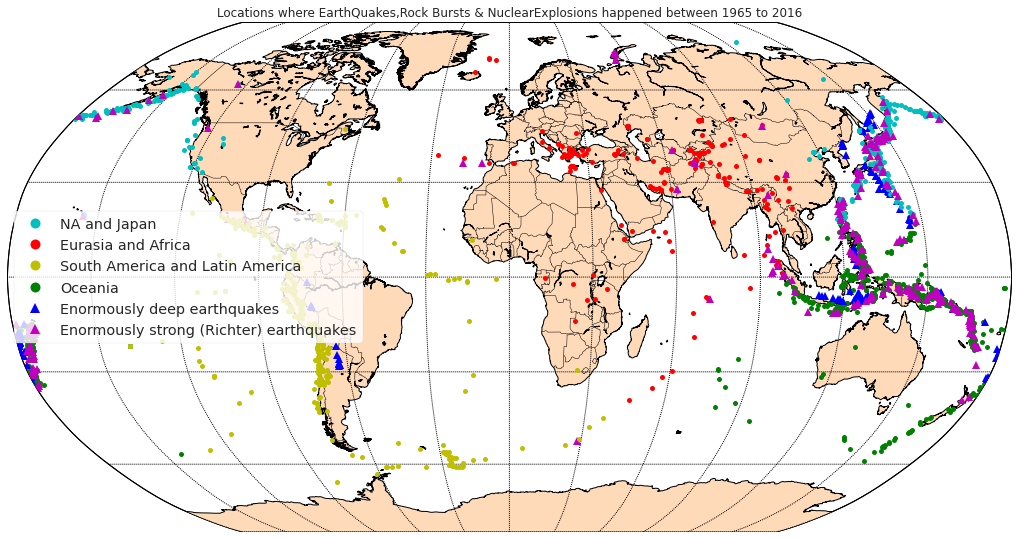

In [ ]:
plt.figure(figsize=(18,10));
my_map = Basemap(projection='robin', lat_0=0, lon_0=0,
              resolution='l', area_thresh=1000.0)
 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color='peachpuff')
my_map.drawmapboundary()
 
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))

markers = ["ro","go","b^","co","m^","yo"]
markersize = [5,5,8,5,8,5]
for i in range (6):
  x,y = my_map(df.loc[df["k_labels"]=="label_{}".format(i)]["Longitude"].ravel(), df.loc[df["k_labels"]=="label_{}".format(i)]["Latitude"].ravel())
  my_map.plot(x, y, markers[i], markersize=markersize[i])
plt.title("Locations where EarthQuakes,Rock Bursts & NuclearExplosions happened between 1965 to 2016")


#Creating Fictional lines to get legend

na = mlines.Line2D([], [], color='c', marker='o', linestyle='None',
                          markersize=10, label='NA and Japan')

eur = mlines.Line2D([], [], color='r', marker='o', linestyle='None',
                          markersize=10, label='Eurasia and Africa')

sa = mlines.Line2D([], [], color='y', marker='o', linestyle='None',
                          markersize=10, label='South America and Latin America')

oc = mlines.Line2D([], [], color='g', marker='o', linestyle='None',
                          markersize=10, label='Oceania')

rch = mlines.Line2D([], [], color='m', marker='^', linestyle='None',
                          markersize=10, label='Enormously strong (Richter) earthquakes')

dp = mlines.Line2D([], [], color='b', marker='^', linestyle='None',
                          markersize=10, label='Enormously deep earthquakes')

plt.legend(handles=[na, eur, sa,oc,dp,rch],fontsize = "x-large")

plt.show()

In [ ]:
w